Getting the dataset

In [18]:
from google.colab import drive
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


drive.mount('/content/drive')

# List files in a directory
!ls '/content/drive/My Drive/AN2DL'


# Load the NPZ file
data = np.load('/content/drive/My Drive/AN2DL/training_set.npz')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
training_set.npz


Data Preprocessing

In [19]:
data.files

['images', 'labels']

In [20]:
images = data['images']
labels = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


In [21]:
labels # labels are already numerical values

array([[7],
       [3],
       [6],
       ...,
       [5],
       [5],
       [5]], dtype=uint8)

In [22]:
def show_example(index_example):
  for i in range(0,100):
    if labels[i] == [index_example]:
      plt.imshow(images[i]/255.0)
      plt.show()
      break

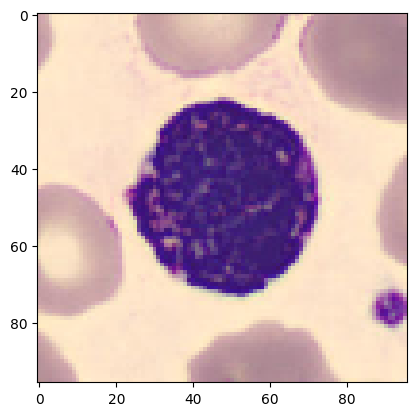

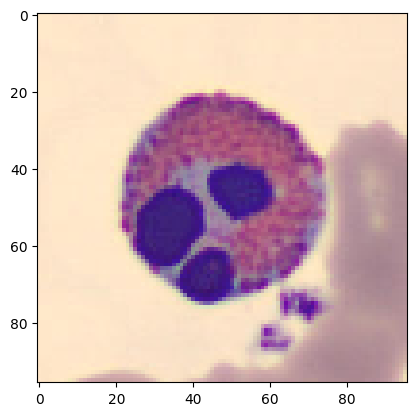

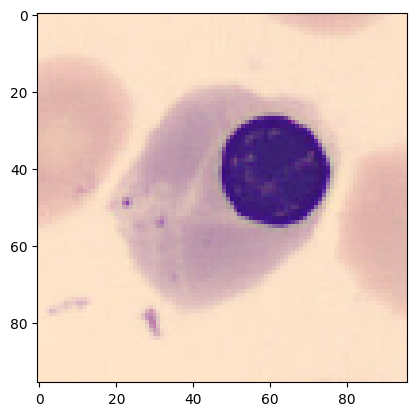

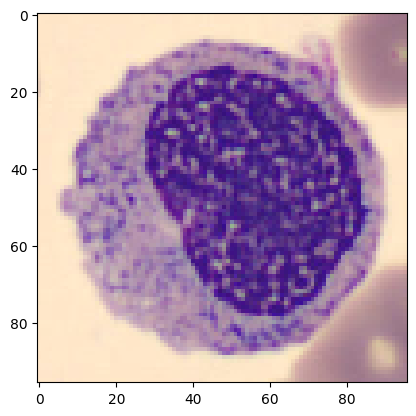

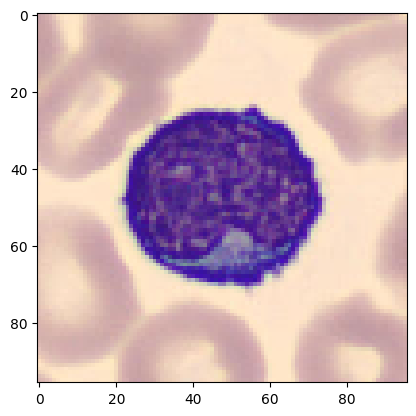

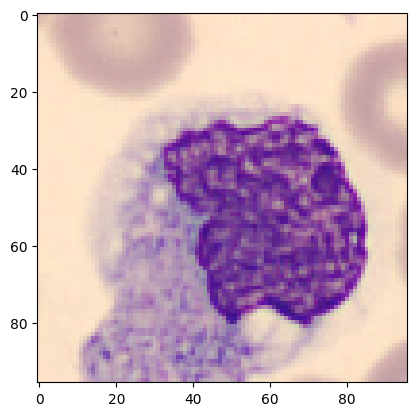

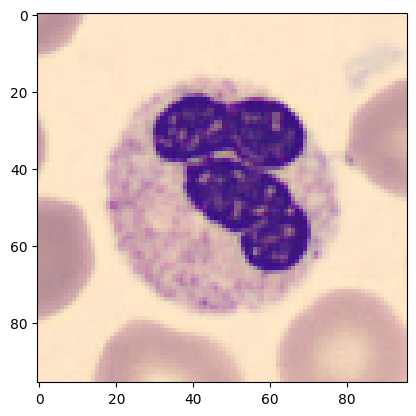

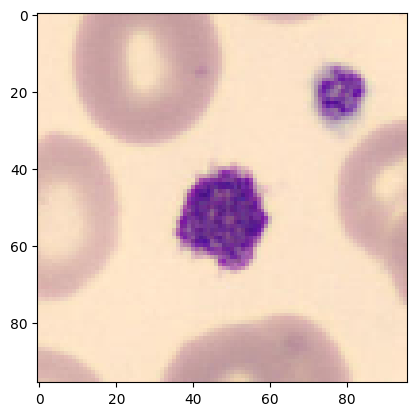

In [23]:
show_example(0)
show_example(1)
show_example(2)
show_example(3)
show_example(4)
show_example(5)
show_example(6)
show_example(7)

In [24]:
# check to see the number of data for each label
data_labels = np.array(["basophil", "eosinophil", "erythroblast", "immature granulocytes", "lymphocyte", "monocyte", "neutrophil", "platelet"])

# Count occurrences of each label
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts for each label
for label, count in zip(unique_labels, counts):
    print(f"{label}: {count}")

0: 1052
1: 2381
2: 1285
3: 2226
4: 1049
5: 1393
6: 2530
7: 1843


In [25]:
import numpy as np
import tensorflow as tf

# Indices for the troll images (known examples)
shrekIdx = 12691
manIdx = 13610

shrek_indices = []
trol_indices = []
new_data = []
new_labels = []
for i, image in enumerate(images):
  if np.sum(images[12691] - image) == 0:
    shrek_indices.append(i)
  elif np.sum(images[13610] - image) == 0:
    trol_indices.append(i)
  else:
    new_data.append(image)
    new_labels.append(labels[i])

new_images = np.array(new_data)
new_dataLabels = np.array(new_labels)

In [26]:
# normalise the data
images = np.array(new_images, dtype=np.float32)  # Convert to float32 for safe division
normalized_images = images / 255.0  # Rescale pixel values to [0, 1]

sample = normalized_images[100]
print('Min:', sample.min(), 'Max:', sample.max())

Min: 0.03137255 Max: 1.0


In [28]:
from sklearn.model_selection import train_test_split

X = normalized_images
y = labels
# Step 1: First, split into train and remaining (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_images, new_dataLabels, test_size=0.2, random_state=42)

# Step 2: Then, split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now, you have:
# X_train, y_train => Training set
# X_val, y_val     => Validation set
# X_test, y_test   => Test set

In [29]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=32

# Create an instance of ImageDataGenerator with desired augmentations
data_gen = ImageDataGenerator(
    rotation_range=20,       # Degree range for random rotations
    width_shift_range=0.2,   # Range (as a fraction of total width) for horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for vertical shifts
    shear_range=0.2,         # Shear Intensity (Shear angle in counter-clockwise direction)
    zoom_range=0.2,          # Range for random zoom
    horizontal_flip=True,    # Randomly flip inputs horizontally
    fill_mode='nearest'      # Strategy for filling in newly created pixels
)

# Apply the data generator to the training data
train_generator = data_gen.flow(X_train, y_train, batch_size=batch_size)

In [30]:
from sklearn.utils.class_weight import compute_class_weight
y_train = y_train.flatten()
unique_classes = np.unique(y_train)
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# The class_weights array corresponds to each unique class in the y_train array
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weight_dict)
# we will use this weights dictionary in the model training

{0: 1.7716666666666667, 1: 0.6798607163160887, 2: 1.380918013856813, 3: 0.7234573502722323, 4: 1.776931649331352, 5: 1.5156844106463878, 6: 0.6464189189189189, 7: 0.9184907834101382}


In [31]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras import layers, models

# Load pre-trained NASNetMobile with input shape (128, 128, 3)
base_model = NASNetMobile(weights='imagenet', input_shape=(96, 96, 3), include_top=False)

# Freeze base model layers
base_model.trainable = False

# Add custom layers on top of NASNetMobile
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')  # Change the output size to match your class count
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

# Set the number of epochs
epochs = 20

# Define the EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    #batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


299/299 ━━━━━━━━━━━━━━━━━━━━ 239s 711ms/step - accuracy: 0.5786 - loss: 1.3394 - val_accuracy: 0.7876 - val_loss: 0.6839
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 254s 685ms/step - accuracy: 0.7467 - loss: 0.7934 - val_accuracy: 0.7985 - val_loss: 0.6050
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 277s 736ms/step - accuracy: 0.7754 - loss: 0.7012 - val_accuracy: 0.8261 - val_loss: 0.5275
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 247s 685ms/step - accuracy: 0.7888 - loss: 0.6500 - val_accuracy: 0.8303 - val_loss: 0.5241
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 266s 697ms/step - accuracy: 0.7971 - loss: 0.6249 - val_accuracy: 0.8378 - val_loss: 0.4907
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 254s 674ms/step - accuracy: 0.8047 - loss: 0.5994 - val_accuracy: 0.8361 - val_loss: 0.4977
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 203s 675ms/step - accuracy: 0.8063 - loss: 0.5840 - val_accuracy: 0.8428 - val_loss: 0.4791
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 204s 681ms/step - accuracy: 0.8034 - loss: 0.58

KeyboardInterrupt: 

In [33]:
# Predict class probabilities
predictions = model.predict(X_test)

# Get the class with the highest probability for each test sample
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 715ms/step - accuracy: 0.8194 - loss: 0.5081
